In [1]:
import pandas as pd

In [2]:
# 데이터 불러오기 (pos 및 특수문자 등 정제된 데이터임. 정제 방법은 깃허브 코드 참고)
# https://github.com/Ryleyun91/Ryles_Practice/tree/main/DACON
train = pd.read_csv('../DATA/train_data.csv')
test = pd.read_csv('../DATA/test_data.csv')

In [3]:
train_data = [str(sent) for sent in train['과제명'] + " " + train['요약문_한글키워드']]
test_data = [str(sent) for sent in test['과제명'] + " " + test['요약문_한글키워드']]

In [4]:
# EDA
train_length = [len(str(sent)) for sent in train_data]
test_length = [len(str(sent)) for sent in test_data]

(array([2.3040e+03, 2.0360e+04, 1.7381e+04, 3.2090e+03, 2.7500e+02,
        3.8000e+01, 6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  3. ,  34.8,  66.6,  98.4, 130.2, 162. , 193.8, 225.6, 257.4,
        289.2, 321. ]),
 <BarContainer object of 10 artists>)

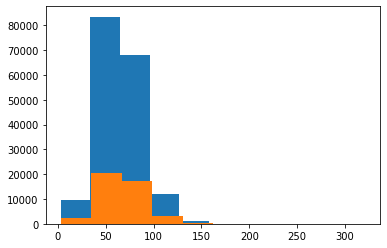

In [5]:
# 시각화
import matplotlib.pyplot as plt

plt.hist(train_length)
plt.hist(test_length)

## max_len 100정도 주면 커버될 듯

In [6]:
# tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index

# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = tokenizer.texts_to_sequences(train_data)
test_seq = tokenizer.texts_to_sequences(test_data)
train_pad = pad_sequences(train_seq, maxlen=100, padding='post', truncating='post')
test_pad = pad_sequences(test_seq, maxlen=100, padding='post', truncating='post')

In [12]:
embedding_dim = 200
max_length = 100
vocab_size = len(word_index)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(46, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          10764000  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_5 (Dense)              (None, 46)                5934      
Total params: 10,795,662
Trainable params: 10,795,662
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_pad, train['label'], epochs=25, batch_size=1000, validation_split=0.1, verbose=2)

Epoch 1/25
157/157 - 14s - loss: 1.4842 - accuracy: 0.8073 - val_loss: 0.9937 - val_accuracy: 0.8192
Epoch 2/25
157/157 - 14s - loss: 0.9522 - accuracy: 0.8178 - val_loss: 0.8888 - val_accuracy: 0.8191
Epoch 3/25
157/157 - 14s - loss: 0.8451 - accuracy: 0.8188 - val_loss: 0.8144 - val_accuracy: 0.8210
Epoch 4/25
157/157 - 14s - loss: 0.7842 - accuracy: 0.8226 - val_loss: 0.7764 - val_accuracy: 0.8255
Epoch 5/25
157/157 - 14s - loss: 0.7188 - accuracy: 0.8332 - val_loss: 0.6931 - val_accuracy: 0.8382
Epoch 6/25
157/157 - 14s - loss: 0.6058 - accuracy: 0.8491 - val_loss: 0.5959 - val_accuracy: 0.8545
Epoch 7/25
157/157 - 14s - loss: 0.5082 - accuracy: 0.8685 - val_loss: 0.5361 - val_accuracy: 0.8633
Epoch 8/25
157/157 - 14s - loss: 0.4407 - accuracy: 0.8812 - val_loss: 0.5005 - val_accuracy: 0.8675
Epoch 9/25
157/157 - 14s - loss: 0.3913 - accuracy: 0.8933 - val_loss: 0.4774 - val_accuracy: 0.8744
Epoch 10/25
157/157 - 14s - loss: 0.3495 - accuracy: 0.9046 - val_loss: 0.4515 - val_accura

In [16]:
# 모델 예측
answer = model.predict(test_pad)

import tensorflow as tf
pred = tf.argmax(answer, axis=1)

<tf.Tensor: shape=(43576,), dtype=int64, numpy=array([ 0,  0,  0, ...,  2,  0, 19])>

In [30]:
sample_submission=pd.read_csv('../DATA/open/sample_submission.csv')
sample_submission['label']=pred
sample_submission.to_csv('../DATA/Result/CNN_basic.csv', index=False)